In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import json
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os

from sklearn.metrics import ConfusionMatrixDisplay

import sys
sys.path.append(os.path.dirname(os.getcwd()))

from constants import TRACKING_SERVER_URI, EXPERIMENT_PREFIX, DATA_DIR, RESULTS_PATH

mlflow.set_tracking_uri(TRACKING_SERVER_URI)

In [4]:
os.environ["MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR"] = "False"

In [5]:
COMPARISON = "ML"
MODEL_ARCHS = ["lstm_v2", "conv", "lstm_conv", "psm"]

In [6]:
with open("../config.json", "r") as f:
    config = json.load(f)

GROUP = "Grupo" + str(config['group'])
print(GROUP)

GROUP_RESULTS_PATH = os.path.join(RESULTS_PATH, GROUP)
if not os.path.exists(GROUP_RESULTS_PATH):
    os.makedirs(GROUP_RESULTS_PATH)
    print(f"{GROUP_RESULTS_PATH} successfully created")
else:
    print(f"{GROUP_RESULTS_PATH} exists")

Grupo1
/home/basbenja/Facultad/TrabajoFinal/results/Grupo1 exists


In [7]:
GROUP_DIR = os.path.join(DATA_DIR, GROUP)
GROUP_PARAMS_FILE = os.path.join(GROUP_DIR, f"params_{GROUP}.json")
if os.path.exists(GROUP_PARAMS_FILE):
    with open(GROUP_PARAMS_FILE, 'r') as f:
        group_params = json.load(f)
else:
    print(f"Group params file not found: {GROUP_PARAMS_FILE}")

REQ_PERIODS = group_params['first_tr_period'] - 1
N_PER_DEP = group_params['n_per_dep']
TR_STARTS = list(range(REQ_PERIODS, REQ_PERIODS + 3))

print(f"Períodos observados:     {REQ_PERIODS}")
print(f"Períodos de dependencia: {N_PER_DEP}")
print(f"Inicios de programa {TR_STARTS}")

Períodos observados:     45
Períodos de dependencia: 20
Inicios de programa [45, 46, 47]


In [8]:
EXPERIMENT_NAME = f"{EXPERIMENT_PREFIX}-{GROUP}-Comp{COMPARISON}"
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = experiment.experiment_id

print(f"{EXPERIMENT_NAME} - ID {experiment_id}")

TF-Grupo1-CompML - ID 425977361629944670


## **Matriz de confusión promedio por arquitectura**

In [19]:
def build_confusion_matrix_from_values(model_arch: str, means: dict[str, float]):
    fig, ax = plt.subplots()

    # Construct confusion matrix from means
    cm = np.array([
        [means['tn'], means['fp']],
        [means['fn'], means['tp']]
    ])

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["NiNi", "Control"]
    )
    disp.plot(ax=ax, cmap='viridis', values_format=".2f")

    if model_arch != 'psm':
        match model_arch:
            case 'lstm_v2': model_title = "LSTM"
            case 'conv': model_title = "Convolucional"
            case 'lstm_conv': model_title = "LSTM + Convolucional"
            case _: model_title = ""
        plot_title = f"Matriz de confusión promedio con la\n arquitectura {model_title}"
    else:
        plot_title = f"Matriz de confusión promedio con PSM"

    ax.set_title(plot_title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Verdadero")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, va="center")
    return fig

In [9]:
results = {}

for model_arch in MODEL_ARCHS:
    model_arch_results = {}

    # Fijamos una arquitectura
    print(f"Getting results for {model_arch}")
    runs = mlflow.search_runs(
        experiment_ids=[experiment_id],
        output_format="list",
        filter_string=f"params.model_arch = '{model_arch}'",
    )

    if len(runs) != 100:
        print(f"{model_arch} doesn't have 100 runs for experiment {EXPERIMENT_NAME}")

    for run in runs:
        # Fijamos una run
        run_info = run.info
        run_artifact_uri = run.info.artifact_uri

        # Juntamos los TP, TN, FP, FN de cada cohorte
        run_results = {}
        for inicio in TR_STARTS:
            dir_name = f"inicio_prog_{inicio}"
            confusion_dict_path = os.path.join(run_artifact_uri, dir_name, 'confusion_dict.json')
            confusion_dict = mlflow.artifacts.load_dict(confusion_dict_path)

            for k, v in confusion_dict.items():
                if k not in run_results:
                    run_results[k] = []
                run_results[k].append(v)

        # Calculamos los promedios de esa simulación y los agregamos al diccionario
        # que tiene los promedios de todas las simulaciones
        for metric, values in run_results.items():
            if metric not in model_arch_results:
                model_arch_results[metric] = []
            mean = float(np.mean(values))
            model_arch_results[metric].append(mean)

    if model_arch not in results:
        results[model_arch] = {}
    for metric, values in model_arch_results.items():
        results[model_arch][metric] = float(np.mean(values))

Getting results for lstm_v2
Getting results for conv
Getting results for lstm_conv
Getting results for psm


/tmp/ipykernel_8349/4096447525.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8349/4096447525.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8349/4096447525.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_8349/4096447525.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


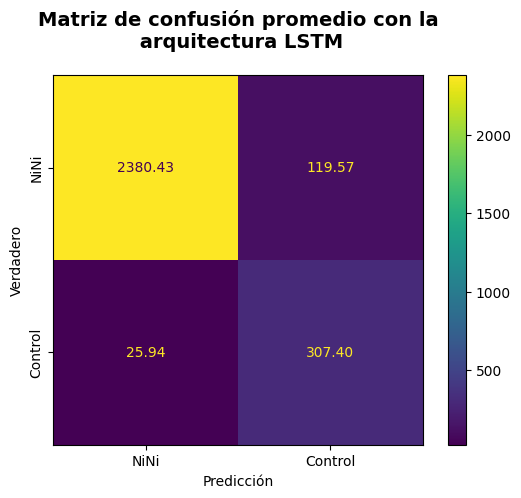

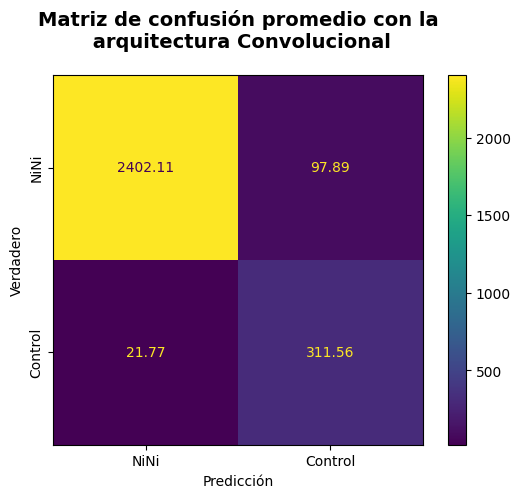

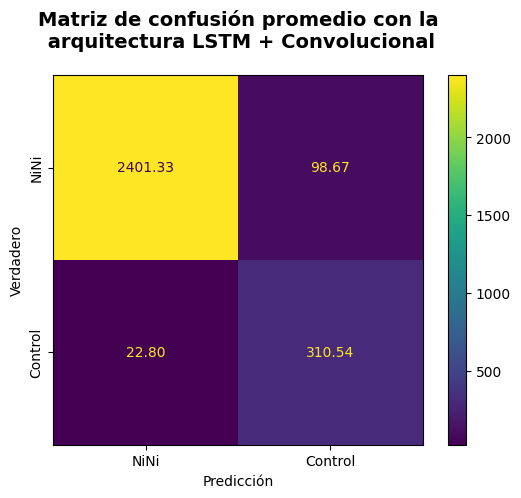

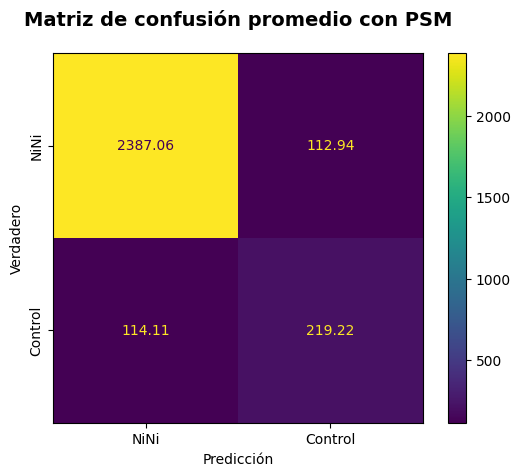

In [20]:
for model_arch, means in results.items():
    fig = build_confusion_matrix_from_values(model_arch, means)
    fig.show()